In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from scipy import stats
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Load dataset
radi = pd.read_csv("sbsppdaa24/train_radiomics_hipocamp.csv")

# Drop unique identifier columns
radi.drop(columns=["Mask", "ID", "Image"], inplace=True)

# Drop non-numeric columns except for 'Transition'
columns_to_drop = [col for col in radi.columns if radi[col].dtype == 'object' and col != 'Transition']
radi.drop(columns=columns_to_drop, inplace=True)
print(f"Dropped {len(columns_to_drop)} non-numeric columns.")

# Drop columns where all entries are the same
same_value_cols = [col for col in radi.columns if radi[col].nunique() == 1]
radi.drop(columns=same_value_cols, inplace=True)
print(f"Dropped {len(same_value_cols)} columns with the same value for every entry.")

# Apply MinMax scaling to float columns
float_cols = radi.select_dtypes(include=['float','int']).columns
scaler = MinMaxScaler()
radi[float_cols] = scaler.fit_transform(radi[float_cols])

# Compute correlation matrix
corr_matrix = radi.drop(["Transition"],axis=1).corr().abs()

# Select upper triangle of correlation matrix to avoid duplicate pairs
upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))

# Find features with correlation above the threshold (e.g., 0.9)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop the highly correlated features directly from 'radi'
initial_feature_count = radi.shape[1]
radi.drop(columns=to_drop, inplace=True)
final_feature_count = radi.shape[1]

print(f"Reduced features from {initial_feature_count} to {final_feature_count}")
radi.info()

Dropped 16 non-numeric columns.
Dropped 148 columns with the same value for every entry.
Reduced features from 2014 to 689
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 689 entries, diagnostics_Image-original_Mean to Transition
dtypes: float64(688), object(1)
memory usage: 1.6+ MB


In [3]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score


# Estado vai ser comum para todos os modelos, 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)
classification_reports = {}

## Bagging

In [4]:
# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"])
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

bagging_params = {"n_estimators": [100,150,300, 500, 800, 1000]}
bagging_model = BaggingClassifier(random_state=2025)
bagging_grid = GridSearchCV(bagging_model, bagging_params, scoring='f1_weighted', cv=skf, n_jobs=-1,verbose=3)
bagging_grid.fit(X_train, y_train)
y_pred_bagging = bagging_grid.best_estimator_.predict(X_test)
classification_reports["Bagging"] = classification_report(y_test, y_pred_bagging, output_dict=True,zero_division=0)
print(f"Best Bagging Model Parameters: {bagging_grid.best_params_}")
print(f"Bagging Classification Report:\n", classification_report(y_test, y_pred_bagging))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Bagging Model Parameters: {'n_estimators': 500}
Bagging Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.86      0.43      0.57        14
       CN-CN       0.54      0.77      0.63        26
      CN-MCI       0.00      0.00      0.00         1
      MCI-AD       0.32      0.43      0.36        14
     MCI-MCI       0.36      0.23      0.28        22

    accuracy                           0.48        77
   macro avg       0.41      0.37      0.37        77
weighted avg       0.50      0.48      0.46        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Random Forest

In [5]:
# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"])
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

# Params Definition
rf_params = {"n_estimators": [100,300,500, 800, 1000], "max_depth": [5, 10, 20, None],"criterion" :["gini","entropy"]}
rf_model = RandomForestClassifier(random_state=2025)

# model, params, scoring using f1, 5 folds, full processor
rf_grid = GridSearchCV(rf_model, rf_params, scoring='f1_weighted', cv=skf, n_jobs=-1)
rf_grid.fit(X_train, y_train)

y_pred_rf = rf_grid.best_estimator_.predict(X_test)
classification_reports["RandomForest"] = classification_report(y_test, y_pred_rf, output_dict=True,zero_division=0)
print(f"Best RandomForest Model Parameters: {rf_grid.best_params_}")
print(f"RandomForest Classification Report:\n", classification_report(y_test, y_pred_rf))

Best RandomForest Model Parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
RandomForest Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.50      0.29      0.36        14
       CN-CN       0.51      0.73      0.60        26
      CN-MCI       0.00      0.00      0.00         1
      MCI-AD       0.20      0.21      0.21        14
     MCI-MCI       0.41      0.32      0.36        22

    accuracy                           0.43        77
   macro avg       0.33      0.31      0.31        77
weighted avg       0.42      0.43      0.41        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Gradient Boosting

In [6]:
# Split data into features and target
df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

# Params Definition
gb_params = {"n_estimators": [500, 600, 1000], "learning_rate": [0.1, 0.3,0.01]}
gb_model = GradientBoostingClassifier(random_state=2025)

# model, params, scoring using f1, 5 folds, full processor
gb_grid = GridSearchCV(gb_model, gb_params, scoring='f1_weighted',cv=skf, n_jobs=-1)
gb_grid.fit(X_train, y_train)

y_pred_gb = gb_grid.best_estimator_.predict(X_test)
classification_reports["GradientBoosting"] = classification_report(y_test, y_pred_gb, output_dict=True,zero_division=0)
print(f"Best GradientBoosting Model Parameters: {gb_grid.best_params_}")
print(f"GradientBoosting Classification Report:\n", classification_report(y_test, y_pred_gb))


Best GradientBoosting Model Parameters: {'learning_rate': 0.01, 'n_estimators': 500}
GradientBoosting Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.38      0.36      0.37        14
       CN-CN       0.53      0.65      0.59        26
      CN-MCI       0.00      0.00      0.00         1
      MCI-AD       0.17      0.14      0.15        14
     MCI-MCI       0.32      0.27      0.29        22

    accuracy                           0.39        77
   macro avg       0.28      0.29      0.28        77
weighted avg       0.37      0.39      0.38        77



## XGBoosting

In [7]:
from sklearn.preprocessing import LabelEncoder

# Copy the dataframe and apply label encoding to the target variable
df = radi.copy()
label_encoder = LabelEncoder()
df['Transition'] = label_encoder.fit_transform(df['Transition'])

# Define features and target
X = df.drop(columns=["Transition"])
y = df["Transition"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

# Define XGBoost hyperparameters and model with a multi-class objective and compatible eval_metric
xgb_params = {
    "n_estimators": [500,1000,600],
    "learning_rate": [0.1,0.3],
    "max_depth": [5,6,8,20],
    
}

xgb_model = XGBClassifier(eval_metric='mlogloss',random_state=2025)

# Run GridSearchCV to find the best parameters
xgb_grid = GridSearchCV(xgb_model, xgb_params, scoring='f1_weighted', cv=skf, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)
classification_reports["XGBoost"] = classification_report(y_test, y_pred_xgb, output_dict=True,zero_division=0)
print(f"Best XGBoost Model Parameters: {xgb_grid.best_params_}")
print(f"XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


Best XGBoost Model Parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 500}
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.43      0.44        14
           1       0.51      0.69      0.59        26
           2       0.00      0.00      0.00         1
           3       0.20      0.21      0.21        14
           4       0.43      0.27      0.33        22

    accuracy                           0.43        77
   macro avg       0.32      0.32      0.31        77
weighted avg       0.42      0.43      0.41        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## SVM

In [8]:
from sklearn.svm import SVC

df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

# Define the parameter grid for SVC
param_grid = {
    'C': [0.1, 1, 10, 100],              # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto'],           # Kernel coefficient for 'rbf' and 'poly' kernels
}

# Initialize the SVC model
svm_model = SVC(random_state=2025)

# Initialize GridSearchCV with cross-validation
svm_grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, 
                           cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

svm_grid.fit(X_train, y_train)
y_pred_svm = svm_grid.best_estimator_.predict(X_test)
classification_reports["SVM"] = classification_report(y_test, y_pred_svm, output_dict=True,zero_division=0)
print(f"Best SVM Model Parameters: {svm_grid.best_params_}")
print(f"SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best SVM Model Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.43      0.21      0.29        14
       CN-CN       0.52      0.85      0.65        26
      CN-MCI       0.00      0.00      0.00         1
      MCI-AD       0.32      0.43      0.36        14
     MCI-MCI       0.44      0.18      0.26        22

    accuracy                           0.45        77
   macro avg       0.34      0.33      0.31        77
weighted avg       0.44      0.45      0.41        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Stacking

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)

meta_model = RandomForestClassifier(random_state=25)

estimators = [("gb", gb_grid.best_estimator_), ("svm", svm_grid.best_estimator_), ("rf", rf_grid.best_estimator_)]
st_model = StackingClassifier(estimators=estimators, final_estimator = meta_model) 
st_model.fit(X_train, y_train)
st_predictions = st_model.predict(X_test)
classification_reports["Stacking"] = classification_report(y_test, st_predictions, output_dict=True,zero_division=0)
print(f"Stacking Classification Report:\n", classification_report(y_test, st_predictions))

[CV 2/5] END ..................n_estimators=100;, score=0.369 total time=   4.3s
[CV 1/5] END ..................n_estimators=300;, score=0.401 total time=  11.8s
[CV 4/5] END ..................n_estimators=500;, score=0.387 total time=  19.7s
[CV 2/5] END .................n_estimators=1000;, score=0.377 total time=  37.7s
[CV 2/5] END ..................n_estimators=150;, score=0.347 total time=   6.1s
[CV 4/5] END ..................n_estimators=300;, score=0.410 total time=  12.1s
[CV 3/5] END ..................n_estimators=800;, score=0.477 total time=  33.0s
[CV 4/5] END ..................n_estimators=100;, score=0.397 total time=   4.5s
[CV 3/5] END ..................n_estimators=300;, score=0.450 total time=  12.4s
[CV 5/5] END ..................n_estimators=500;, score=0.354 total time=  19.8s
[CV 3/5] END .................n_estimators=1000;, score=0.492 total time=  37.6s
[CV 3/5] END ..................n_estimators=150;, score=0.498 total time=   6.5s
[CV 1/5] END ...............

/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Max Voting

In [10]:
from sklearn.ensemble import VotingClassifier

df = radi.copy()
X = df.drop(columns=["Transition"]) 
y = df["Transition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2025)


estimators = [("gb", gb_grid.best_estimator_), ("svm", svm_grid.best_estimator_), ("rf", rf_grid.best_estimator_)]
vt_model = VotingClassifier(estimators=estimators, voting = 'hard', weights = [3,2,1]) 
vt_model.fit(X_train, y_train)
vt_predictions = vt_model.predict(X_test)
classification_reports["Voting"] = classification_report(y_test, vt_predictions, output_dict=True,zero_division=0)
print(f"Voting Classification Report:\n", classification_report(y_test, st_predictions))

Voting Classification Report:
               precision    recall  f1-score   support

       AD-AD       0.36      0.29      0.32        14
       CN-CN       0.53      0.73      0.61        26
      CN-MCI       0.00      0.00      0.00         1
      MCI-AD       0.31      0.36      0.33        14
     MCI-MCI       0.14      0.09      0.11        22

    accuracy                           0.39        77
   macro avg       0.27      0.29      0.28        77
weighted avg       0.34      0.39      0.36        77



/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nunorodrigues/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Ver Resultados

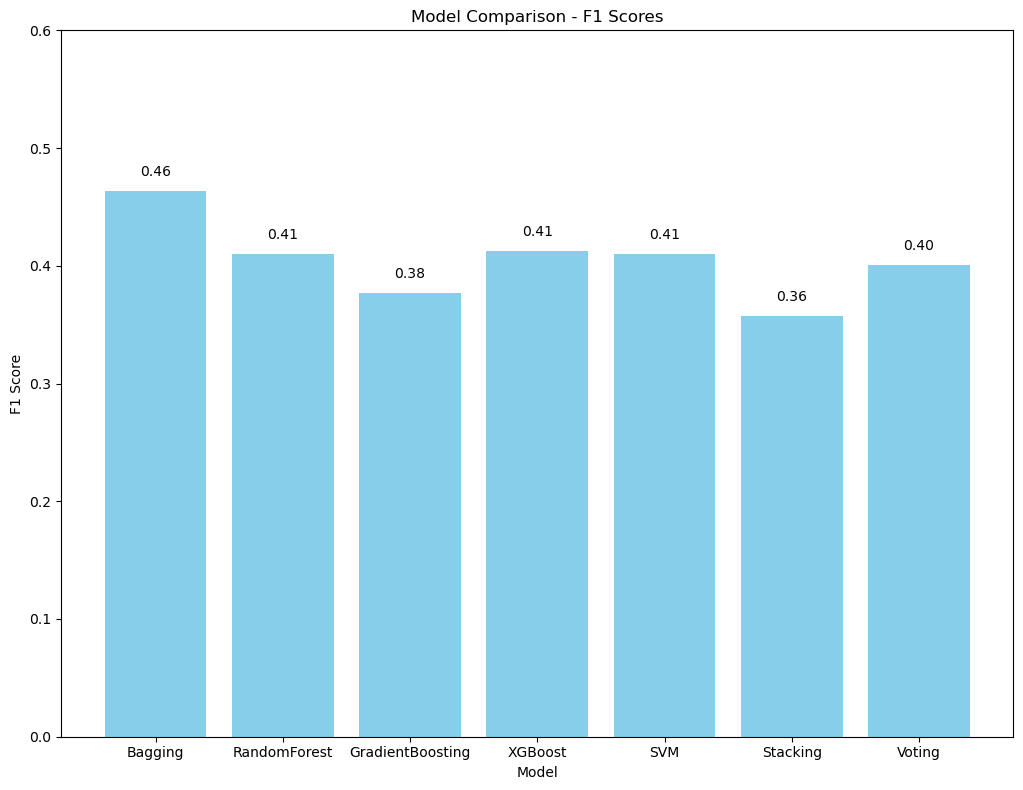

In [11]:
import matplotlib.pyplot as plt

# Assuming f1_scores is already defined
f1_scores = {model: report["weighted avg"]["f1-score"] for model, report in classification_reports.items()}

# Plotting
plt.figure(figsize=(20, 8))

# F1 Score Graph
plt.subplot(1, 2, 1)
bars = plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("Model Comparison - F1 Scores")
plt.ylim(0, 0.6)

# Display values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


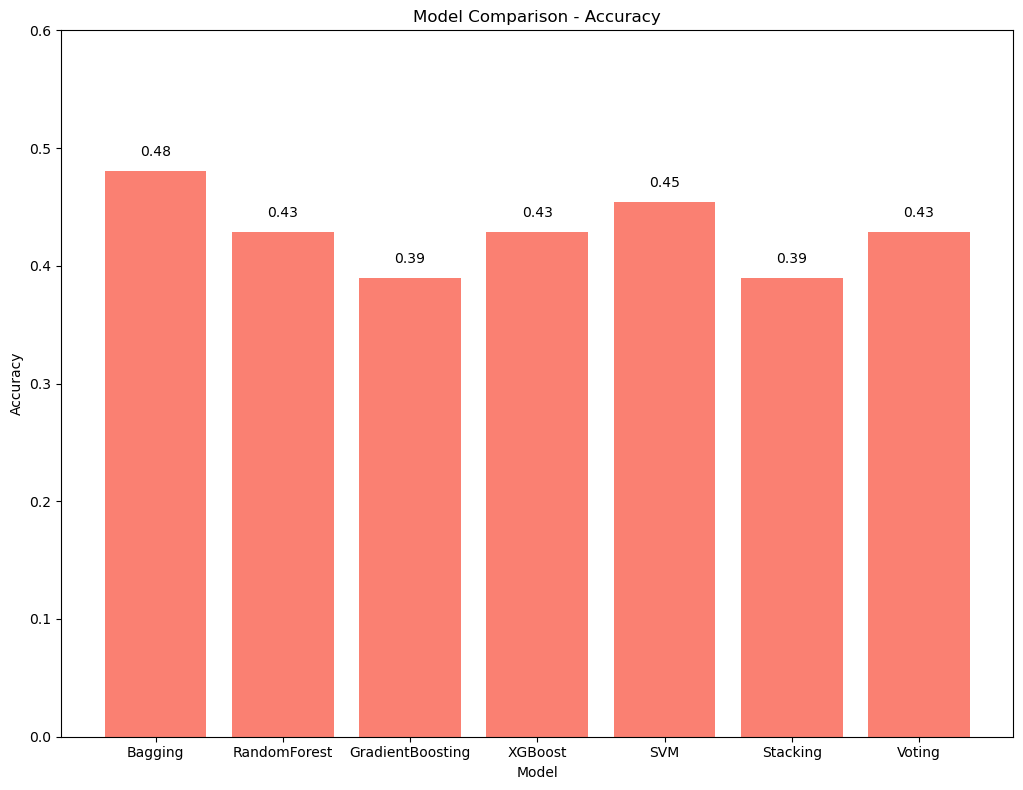

In [12]:
accuracies = {model: report["accuracy"] for model, report in classification_reports.items()}

# Accuracy Graph
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 2)
bars = plt.bar(accuracies.keys(), accuracies.values(), color='salmon')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Comparison - Accuracy")
plt.ylim(0, 0.6)


# Display values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Generating csv

In [13]:
# Load the test dataset
test_data = pd.read_csv("sbsppdaa24/test_radiomics_hipocamp.csv")

test_data[float_cols] = scaler.transform(test_data[float_cols])
# Apply the same preprocessing as in the training phase
# Drop unused columns to match the training features
test_data = test_data[radi.drop(["Transition"],axis=1).columns]

# Apply the previously fitted scaler to the test data

# Generate predictions using the Bagging model
bg_predictions_test = bagging_grid.best_estimator_.predict(test_data)

# Generate predictions using the RandomForest model
rf_predictions_test = rf_grid.best_estimator_.predict(test_data)

# Generate predictions using the Gradient Boosting model
gb_predictions_test = gb_grid.best_estimator_.predict(test_data)

# Generate predictions using the Voting model
vb_predictions_test = vt_model.predict(test_data)

# Store each model's predictions in separate DataFrames and save to CSV
res0 = pd.DataFrame({
    'RowId': range(1, len(bg_predictions_test) + 1),
    'Result': bg_predictions_test 
})
res0.to_csv('BaggingGrid4.0.csv', index=False)

res1 = pd.DataFrame({
    'RowId': range(1, len(rf_predictions_test) + 1),
    'Result': rf_predictions_test
})
res1.to_csv('RandomForestGrid4.0.csv', index=False)

res2 = pd.DataFrame({
    'RowId': range(1, len(gb_predictions_test) + 1),
    'Result': gb_predictions_test
})
res2.to_csv('GradientBoostingGrid4.0.csv', index=False)

res3 = pd.DataFrame({
    'RowId': range(1, len(vb_predictions_test) + 1),
    'Result': vb_predictions_test
})
res3.to_csv('Voting4.0.csv', index=False)


[CV 3/5] END ..................n_estimators=150;, score=0.402 total time=  10.9s
[CV 1/5] END ..................n_estimators=500;, score=0.311 total time=  32.8s
[CV 4/5] END ..................n_estimators=800;, score=0.276 total time=  31.1s
[CV 2/5] END ..................n_estimators=150;, score=0.264 total time=  10.7s
[CV 5/5] END ..................n_estimators=300;, score=0.291 total time=  20.8s
[CV 3/5] END ..................n_estimators=800;, score=0.379 total time=  35.7s
[CV 2/5] END ..................n_estimators=100;, score=0.281 total time=   7.0s
[CV 5/5] END ..................n_estimators=150;, score=0.319 total time=  10.4s
[CV 2/5] END ..................n_estimators=500;, score=0.289 total time=  30.0s
[CV 5/5] END ..................n_estimators=800;, score=0.290 total time=  30.3s
[CV 3/5] END ..................n_estimators=100;, score=0.399 total time=   7.1s
[CV 1/5] END ..................n_estimators=300;, score=0.322 total time=  20.4s
[CV 4/5] END ...............